In [1]:
"""
Author: Alan, Chen
Email: alanchen0922@gmail.com

paper: https://arxiv.org/abs/1611.08024
"""

'\nAuthor: Alan, Chen\nEmail: alanchen0922@gmail.com\n\npaper: https://arxiv.org/abs/1611.08024\n'

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Function
import numpy as np
from EEGNet import *
from DeepConvNet import *
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [29]:
def read_bci_data():
    S4b_train = np.load('S4b_train.npz')
    X11b_train = np.load('X11b_train.npz')
    S4b_test = np.load('S4b_test.npz')
    X11b_test = np.load('X11b_test.npz')

    train_data = np.concatenate((S4b_train['signal'], X11b_train['signal']), axis=0)
    train_label = np.concatenate((S4b_train['label'], X11b_train['label']), axis=0)
    test_data = np.concatenate((S4b_test['signal'], X11b_test['signal']), axis=0)
    test_label = np.concatenate((S4b_test['label'], X11b_test['label']), axis=0)

    train_label = train_label - 1
    test_label = test_label -1
    train_data = np.transpose(np.expand_dims(train_data, axis=1), (0, 1, 3, 2))
    test_data = np.transpose(np.expand_dims(test_data, axis=1), (0, 1, 3, 2))

    mask = np.where(np.isnan(train_data))
    train_data[mask] = np.nanmean(train_data)

    mask = np.where(np.isnan(test_data))
    test_data[mask] = np.nanmean(test_data)

    print(train_data.shape, train_label.shape, test_data.shape, test_label.shape)

    return train_data, train_label, test_data, test_label

In [45]:
# model = EEGNet_relu().to(device)
# model = EEGNet_lrelu().to(device)
# model = EEGNet_elu().to(device)
# model = DeepConvNet_relu().to(device)
# model = DeepConvNet_lrelu().to(device)
model = DeepConvNet_elu().to(device)
# print(model)
summary(model, (1, 2, 750))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 25, 2, 746]             150
            Conv2d-2           [-1, 25, 1, 746]           1,275
       BatchNorm2d-3           [-1, 25, 1, 746]              50
         MaxPool2d-4           [-1, 25, 1, 373]               0
           Dropout-5           [-1, 25, 1, 373]               0
            Conv2d-6           [-1, 50, 1, 369]           6,300
       BatchNorm2d-7           [-1, 50, 1, 369]             100
         MaxPool2d-8           [-1, 50, 1, 184]               0
           Dropout-9           [-1, 50, 1, 184]               0
           Conv2d-10          [-1, 100, 1, 180]          25,100
      BatchNorm2d-11          [-1, 100, 1, 180]             200
        MaxPool2d-12           [-1, 100, 1, 90]               0
          Dropout-13           [-1, 100, 1, 90]               0
           Conv2d-14           [-1, 200

In [46]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    avg_loss, avg_acc = 0, 0
    for batch, (x, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item()
        avg_acc += (pred.argmax(1) == y).type(torch.float).sum().item()
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
    avg_loss /= len(dataloader)
    avg_acc /= len(dataloader.dataset)
    return 100*avg_acc, avg_loss


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return 100*correct, test_loss

In [47]:
from sklearn import preprocessing

x_train, y_train, x_test, y_test = read_bci_data()

x_train = torch.from_numpy(x_train).float().to(device)
y_train = torch.from_numpy(y_train).type(torch.LongTensor).to(device)

x_test = torch.from_numpy(x_test).float().to(device)
y_test = torch.from_numpy(y_test).type(torch.LongTensor).to(device) # data type is long

train = torch.utils.data.TensorDataset(x_train,y_train)
test = torch.utils.data.TensorDataset(x_test,y_test)

batch_size = 128
train_loader = DataLoader(
    dataset=train,
    batch_size=batch_size,
    shuffle=True,
)

test_loader = DataLoader(
    dataset=test,
    batch_size=batch_size,
    shuffle=True,
)

epochs = 2000
learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.02)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)


In [48]:
train_acc = []
train_loss = []
test_acc = []
test_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    tr_acc, tr_loss = train_loop(train_loader, model, loss_fn, optimizer)
    te_acc, te_loss = test_loop(test_loader, model, loss_fn)
    train_acc.append(tr_acc)
    train_loss.append(tr_loss)
    test_acc.append(te_acc)
    test_loss.append(te_loss)
    if te_acc > 88.5 and t > 300:
        break
print("Done!")

print("Saving model weight...")
torch.save(model, "./model.pt")
print("Save Done!")

Epoch 1
-------------------------------
loss: 0.779105  [    0/ 1080]
Test Error: 
 Accuracy: 52.5%, Avg loss: 1.254786 

Epoch 2
-------------------------------
loss: 1.192939  [    0/ 1080]
Test Error: 
 Accuracy: 63.0%, Avg loss: 0.913886 

Epoch 3
-------------------------------
loss: 0.877697  [    0/ 1080]
Test Error: 
 Accuracy: 68.7%, Avg loss: 0.735425 

Epoch 4
-------------------------------
loss: 0.728831  [    0/ 1080]
Test Error: 
 Accuracy: 66.9%, Avg loss: 0.660322 

Epoch 5
-------------------------------
loss: 0.590958  [    0/ 1080]
Test Error: 
 Accuracy: 66.4%, Avg loss: 0.651074 

Epoch 6
-------------------------------
loss: 0.554160  [    0/ 1080]
Test Error: 
 Accuracy: 70.5%, Avg loss: 0.639190 

Epoch 7
-------------------------------
loss: 0.530749  [    0/ 1080]
Test Error: 
 Accuracy: 69.2%, Avg loss: 0.611301 

Epoch 8
-------------------------------
loss: 0.575317  [    0/ 1080]
Test Error: 
 Accuracy: 70.7%, Avg loss: 0.604215 

Epoch 9
----------------

Test Error: 
 Accuracy: 74.5%, Avg loss: 0.660036 

Epoch 69
-------------------------------
loss: 0.258160  [    0/ 1080]
Test Error: 
 Accuracy: 75.6%, Avg loss: 0.613037 

Epoch 70
-------------------------------
loss: 0.236336  [    0/ 1080]
Test Error: 
 Accuracy: 76.7%, Avg loss: 0.620783 

Epoch 71
-------------------------------
loss: 0.176800  [    0/ 1080]
Test Error: 
 Accuracy: 76.6%, Avg loss: 0.636774 

Epoch 72
-------------------------------
loss: 0.274222  [    0/ 1080]
Test Error: 
 Accuracy: 76.8%, Avg loss: 0.610490 

Epoch 73
-------------------------------
loss: 0.202920  [    0/ 1080]
Test Error: 
 Accuracy: 75.8%, Avg loss: 0.604111 

Epoch 74
-------------------------------
loss: 0.193151  [    0/ 1080]
Test Error: 
 Accuracy: 75.8%, Avg loss: 0.662115 

Epoch 75
-------------------------------
loss: 0.214734  [    0/ 1080]
Test Error: 
 Accuracy: 76.5%, Avg loss: 0.574090 

Epoch 76
-------------------------------
loss: 0.196117  [    0/ 1080]
Test Error: 
 Ac

Test Error: 
 Accuracy: 77.4%, Avg loss: 0.572446 

Epoch 136
-------------------------------
loss: 0.123291  [    0/ 1080]
Test Error: 
 Accuracy: 78.0%, Avg loss: 0.535950 

Epoch 137
-------------------------------
loss: 0.108964  [    0/ 1080]
Test Error: 
 Accuracy: 77.0%, Avg loss: 0.543095 

Epoch 138
-------------------------------
loss: 0.126302  [    0/ 1080]
Test Error: 
 Accuracy: 76.6%, Avg loss: 0.548908 

Epoch 139
-------------------------------
loss: 0.106103  [    0/ 1080]
Test Error: 
 Accuracy: 80.6%, Avg loss: 0.514462 

Epoch 140
-------------------------------
loss: 0.112035  [    0/ 1080]
Test Error: 
 Accuracy: 78.9%, Avg loss: 0.509460 

Epoch 141
-------------------------------
loss: 0.149742  [    0/ 1080]
Test Error: 
 Accuracy: 77.9%, Avg loss: 0.540685 

Epoch 142
-------------------------------
loss: 0.145944  [    0/ 1080]
Test Error: 
 Accuracy: 78.2%, Avg loss: 0.545488 

Epoch 143
-------------------------------
loss: 0.131334  [    0/ 1080]
Test Err

Test Error: 
 Accuracy: 78.1%, Avg loss: 0.558273 

Epoch 203
-------------------------------
loss: 0.128208  [    0/ 1080]
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.554214 

Epoch 204
-------------------------------
loss: 0.147850  [    0/ 1080]
Test Error: 
 Accuracy: 77.9%, Avg loss: 0.524267 

Epoch 205
-------------------------------
loss: 0.116282  [    0/ 1080]
Test Error: 
 Accuracy: 76.9%, Avg loss: 0.540370 

Epoch 206
-------------------------------
loss: 0.109213  [    0/ 1080]
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.531905 

Epoch 207
-------------------------------
loss: 0.124968  [    0/ 1080]
Test Error: 
 Accuracy: 78.3%, Avg loss: 0.522435 

Epoch 208
-------------------------------
loss: 0.143197  [    0/ 1080]
Test Error: 
 Accuracy: 79.3%, Avg loss: 0.516348 

Epoch 209
-------------------------------
loss: 0.133846  [    0/ 1080]
Test Error: 
 Accuracy: 79.3%, Avg loss: 0.541424 

Epoch 210
-------------------------------
loss: 0.135885  [    0/ 1080]
Test Err

Test Error: 
 Accuracy: 78.1%, Avg loss: 0.531265 

Epoch 270
-------------------------------
loss: 0.140328  [    0/ 1080]
Test Error: 
 Accuracy: 77.1%, Avg loss: 0.538427 

Epoch 271
-------------------------------
loss: 0.120031  [    0/ 1080]
Test Error: 
 Accuracy: 78.9%, Avg loss: 0.570021 

Epoch 272
-------------------------------
loss: 0.146451  [    0/ 1080]
Test Error: 
 Accuracy: 77.7%, Avg loss: 0.518051 

Epoch 273
-------------------------------
loss: 0.132262  [    0/ 1080]
Test Error: 
 Accuracy: 79.5%, Avg loss: 0.498100 

Epoch 274
-------------------------------
loss: 0.154030  [    0/ 1080]
Test Error: 
 Accuracy: 78.4%, Avg loss: 0.535491 

Epoch 275
-------------------------------
loss: 0.112638  [    0/ 1080]
Test Error: 
 Accuracy: 76.7%, Avg loss: 0.547470 

Epoch 276
-------------------------------
loss: 0.145196  [    0/ 1080]
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.523282 

Epoch 277
-------------------------------
loss: 0.118641  [    0/ 1080]
Test Err

Test Error: 
 Accuracy: 78.9%, Avg loss: 0.522333 

Epoch 337
-------------------------------
loss: 0.090479  [    0/ 1080]
Test Error: 
 Accuracy: 79.7%, Avg loss: 0.498771 

Epoch 338
-------------------------------
loss: 0.157409  [    0/ 1080]
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.517621 

Epoch 339
-------------------------------
loss: 0.138644  [    0/ 1080]
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.524746 

Epoch 340
-------------------------------
loss: 0.136434  [    0/ 1080]
Test Error: 
 Accuracy: 79.2%, Avg loss: 0.526866 

Epoch 341
-------------------------------
loss: 0.172043  [    0/ 1080]
Test Error: 
 Accuracy: 75.6%, Avg loss: 0.566996 

Epoch 342
-------------------------------
loss: 0.148284  [    0/ 1080]
Test Error: 
 Accuracy: 78.3%, Avg loss: 0.521857 

Epoch 343
-------------------------------
loss: 0.160100  [    0/ 1080]
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.542199 

Epoch 344
-------------------------------
loss: 0.140143  [    0/ 1080]
Test Err

Test Error: 
 Accuracy: 78.7%, Avg loss: 0.537042 

Epoch 404
-------------------------------
loss: 0.103136  [    0/ 1080]
Test Error: 
 Accuracy: 79.4%, Avg loss: 0.514490 

Epoch 405
-------------------------------
loss: 0.166326  [    0/ 1080]
Test Error: 
 Accuracy: 77.5%, Avg loss: 0.545989 

Epoch 406
-------------------------------
loss: 0.088440  [    0/ 1080]
Test Error: 
 Accuracy: 78.5%, Avg loss: 0.548229 

Epoch 407
-------------------------------
loss: 0.132725  [    0/ 1080]
Test Error: 
 Accuracy: 78.7%, Avg loss: 0.511320 

Epoch 408
-------------------------------
loss: 0.127208  [    0/ 1080]
Test Error: 
 Accuracy: 77.7%, Avg loss: 0.538906 

Epoch 409
-------------------------------
loss: 0.111972  [    0/ 1080]
Test Error: 
 Accuracy: 78.9%, Avg loss: 0.494739 

Epoch 410
-------------------------------
loss: 0.130872  [    0/ 1080]
Test Error: 
 Accuracy: 79.2%, Avg loss: 0.537150 

Epoch 411
-------------------------------
loss: 0.158710  [    0/ 1080]
Test Err

Test Error: 
 Accuracy: 79.4%, Avg loss: 0.498715 

Epoch 471
-------------------------------
loss: 0.106300  [    0/ 1080]
Test Error: 
 Accuracy: 80.1%, Avg loss: 0.524135 

Epoch 472
-------------------------------
loss: 0.151920  [    0/ 1080]
Test Error: 
 Accuracy: 78.8%, Avg loss: 0.506923 

Epoch 473
-------------------------------
loss: 0.113818  [    0/ 1080]
Test Error: 
 Accuracy: 78.2%, Avg loss: 0.545440 

Epoch 474
-------------------------------
loss: 0.123699  [    0/ 1080]
Test Error: 
 Accuracy: 77.5%, Avg loss: 0.556947 

Epoch 475
-------------------------------
loss: 0.123442  [    0/ 1080]
Test Error: 
 Accuracy: 78.9%, Avg loss: 0.547127 

Epoch 476
-------------------------------
loss: 0.135011  [    0/ 1080]
Test Error: 
 Accuracy: 77.1%, Avg loss: 0.552768 

Epoch 477
-------------------------------
loss: 0.160238  [    0/ 1080]
Test Error: 
 Accuracy: 77.9%, Avg loss: 0.529866 

Epoch 478
-------------------------------
loss: 0.092615  [    0/ 1080]
Test Err

Test Error: 
 Accuracy: 78.2%, Avg loss: 0.542252 

Epoch 538
-------------------------------
loss: 0.112821  [    0/ 1080]
Test Error: 
 Accuracy: 78.7%, Avg loss: 0.550337 

Epoch 539
-------------------------------
loss: 0.138374  [    0/ 1080]
Test Error: 
 Accuracy: 79.1%, Avg loss: 0.530691 

Epoch 540
-------------------------------
loss: 0.109583  [    0/ 1080]
Test Error: 
 Accuracy: 80.3%, Avg loss: 0.543613 

Epoch 541
-------------------------------
loss: 0.152712  [    0/ 1080]
Test Error: 
 Accuracy: 78.4%, Avg loss: 0.534139 

Epoch 542
-------------------------------
loss: 0.107860  [    0/ 1080]
Test Error: 
 Accuracy: 78.4%, Avg loss: 0.543903 

Epoch 543
-------------------------------
loss: 0.125985  [    0/ 1080]
Test Error: 
 Accuracy: 76.4%, Avg loss: 0.596169 

Epoch 544
-------------------------------
loss: 0.092230  [    0/ 1080]
Test Error: 
 Accuracy: 77.0%, Avg loss: 0.545301 

Epoch 545
-------------------------------
loss: 0.093204  [    0/ 1080]
Test Err

Test Error: 
 Accuracy: 78.7%, Avg loss: 0.541691 

Epoch 605
-------------------------------
loss: 0.145444  [    0/ 1080]
Test Error: 
 Accuracy: 75.9%, Avg loss: 0.559076 

Epoch 606
-------------------------------
loss: 0.159643  [    0/ 1080]
Test Error: 
 Accuracy: 78.6%, Avg loss: 0.509321 

Epoch 607
-------------------------------
loss: 0.143160  [    0/ 1080]
Test Error: 
 Accuracy: 77.9%, Avg loss: 0.534560 

Epoch 608
-------------------------------
loss: 0.158307  [    0/ 1080]
Test Error: 
 Accuracy: 78.2%, Avg loss: 0.540693 

Epoch 609
-------------------------------
loss: 0.128599  [    0/ 1080]
Test Error: 
 Accuracy: 76.9%, Avg loss: 0.528283 

Epoch 610
-------------------------------
loss: 0.127106  [    0/ 1080]
Test Error: 
 Accuracy: 77.5%, Avg loss: 0.547908 

Epoch 611
-------------------------------
loss: 0.122010  [    0/ 1080]
Test Error: 
 Accuracy: 78.4%, Avg loss: 0.551535 

Epoch 612
-------------------------------
loss: 0.089394  [    0/ 1080]
Test Err

Test Error: 
 Accuracy: 77.8%, Avg loss: 0.545464 

Epoch 672
-------------------------------
loss: 0.116528  [    0/ 1080]
Test Error: 
 Accuracy: 79.6%, Avg loss: 0.511581 

Epoch 673
-------------------------------
loss: 0.092670  [    0/ 1080]
Test Error: 
 Accuracy: 79.2%, Avg loss: 0.550127 

Epoch 674
-------------------------------
loss: 0.127930  [    0/ 1080]
Test Error: 
 Accuracy: 79.4%, Avg loss: 0.563902 

Epoch 675
-------------------------------
loss: 0.106930  [    0/ 1080]
Test Error: 
 Accuracy: 76.7%, Avg loss: 0.559622 

Epoch 676
-------------------------------
loss: 0.113943  [    0/ 1080]
Test Error: 
 Accuracy: 80.4%, Avg loss: 0.507143 

Epoch 677
-------------------------------
loss: 0.123374  [    0/ 1080]
Test Error: 
 Accuracy: 79.2%, Avg loss: 0.517490 

Epoch 678
-------------------------------
loss: 0.181126  [    0/ 1080]
Test Error: 
 Accuracy: 77.6%, Avg loss: 0.517432 

Epoch 679
-------------------------------
loss: 0.123294  [    0/ 1080]
Test Err

Test Error: 
 Accuracy: 79.1%, Avg loss: 0.526006 

Epoch 739
-------------------------------
loss: 0.117537  [    0/ 1080]
Test Error: 
 Accuracy: 78.3%, Avg loss: 0.535023 

Epoch 740
-------------------------------
loss: 0.137043  [    0/ 1080]
Test Error: 
 Accuracy: 78.3%, Avg loss: 0.526695 

Epoch 741
-------------------------------
loss: 0.138766  [    0/ 1080]
Test Error: 
 Accuracy: 78.9%, Avg loss: 0.528145 

Epoch 742
-------------------------------
loss: 0.124227  [    0/ 1080]
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.538498 

Epoch 743
-------------------------------
loss: 0.093447  [    0/ 1080]
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.538916 

Epoch 744
-------------------------------
loss: 0.118495  [    0/ 1080]
Test Error: 
 Accuracy: 77.5%, Avg loss: 0.555770 

Epoch 745
-------------------------------
loss: 0.145002  [    0/ 1080]
Test Error: 
 Accuracy: 78.7%, Avg loss: 0.531114 

Epoch 746
-------------------------------
loss: 0.095100  [    0/ 1080]
Test Err

Test Error: 
 Accuracy: 79.0%, Avg loss: 0.577907 

Epoch 806
-------------------------------
loss: 0.102114  [    0/ 1080]
Test Error: 
 Accuracy: 75.5%, Avg loss: 0.574399 

Epoch 807
-------------------------------
loss: 0.115888  [    0/ 1080]
Test Error: 
 Accuracy: 77.3%, Avg loss: 0.557322 

Epoch 808
-------------------------------
loss: 0.112985  [    0/ 1080]
Test Error: 
 Accuracy: 78.9%, Avg loss: 0.544709 

Epoch 809
-------------------------------
loss: 0.137708  [    0/ 1080]
Test Error: 
 Accuracy: 77.1%, Avg loss: 0.577789 

Epoch 810
-------------------------------
loss: 0.129323  [    0/ 1080]
Test Error: 
 Accuracy: 78.7%, Avg loss: 0.527802 

Epoch 811
-------------------------------
loss: 0.133183  [    0/ 1080]
Test Error: 
 Accuracy: 77.9%, Avg loss: 0.570023 

Epoch 812
-------------------------------
loss: 0.119839  [    0/ 1080]
Test Error: 
 Accuracy: 78.8%, Avg loss: 0.531935 

Epoch 813
-------------------------------
loss: 0.147057  [    0/ 1080]
Test Err

Test Error: 
 Accuracy: 77.1%, Avg loss: 0.552646 

Epoch 873
-------------------------------
loss: 0.083561  [    0/ 1080]
Test Error: 
 Accuracy: 78.3%, Avg loss: 0.530416 

Epoch 874
-------------------------------
loss: 0.107291  [    0/ 1080]
Test Error: 
 Accuracy: 78.7%, Avg loss: 0.543774 

Epoch 875
-------------------------------
loss: 0.108380  [    0/ 1080]
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.560280 

Epoch 876
-------------------------------
loss: 0.095763  [    0/ 1080]
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.549250 

Epoch 877
-------------------------------
loss: 0.096257  [    0/ 1080]
Test Error: 
 Accuracy: 78.4%, Avg loss: 0.531238 

Epoch 878
-------------------------------
loss: 0.097982  [    0/ 1080]
Test Error: 
 Accuracy: 76.6%, Avg loss: 0.561273 

Epoch 879
-------------------------------
loss: 0.110712  [    0/ 1080]
Test Error: 
 Accuracy: 78.8%, Avg loss: 0.525520 

Epoch 880
-------------------------------
loss: 0.150971  [    0/ 1080]
Test Err

Test Error: 
 Accuracy: 81.3%, Avg loss: 0.540550 

Epoch 940
-------------------------------
loss: 0.124995  [    0/ 1080]
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.531152 

Epoch 941
-------------------------------
loss: 0.189987  [    0/ 1080]
Test Error: 
 Accuracy: 79.5%, Avg loss: 0.539419 

Epoch 942
-------------------------------
loss: 0.094794  [    0/ 1080]
Test Error: 
 Accuracy: 79.1%, Avg loss: 0.544402 

Epoch 943
-------------------------------
loss: 0.124723  [    0/ 1080]
Test Error: 
 Accuracy: 79.9%, Avg loss: 0.500160 

Epoch 944
-------------------------------
loss: 0.162482  [    0/ 1080]
Test Error: 
 Accuracy: 78.3%, Avg loss: 0.539094 

Epoch 945
-------------------------------
loss: 0.129712  [    0/ 1080]
Test Error: 
 Accuracy: 78.2%, Avg loss: 0.542666 

Epoch 946
-------------------------------
loss: 0.094672  [    0/ 1080]
Test Error: 
 Accuracy: 77.6%, Avg loss: 0.542880 

Epoch 947
-------------------------------
loss: 0.122030  [    0/ 1080]
Test Err

Test Error: 
 Accuracy: 77.1%, Avg loss: 0.558191 

Epoch 1007
-------------------------------
loss: 0.131386  [    0/ 1080]
Test Error: 
 Accuracy: 77.9%, Avg loss: 0.542742 

Epoch 1008
-------------------------------
loss: 0.078095  [    0/ 1080]
Test Error: 
 Accuracy: 77.4%, Avg loss: 0.528894 

Epoch 1009
-------------------------------
loss: 0.140141  [    0/ 1080]
Test Error: 
 Accuracy: 78.4%, Avg loss: 0.515539 

Epoch 1010
-------------------------------
loss: 0.136525  [    0/ 1080]
Test Error: 
 Accuracy: 77.7%, Avg loss: 0.526346 

Epoch 1011
-------------------------------
loss: 0.137386  [    0/ 1080]
Test Error: 
 Accuracy: 79.2%, Avg loss: 0.507291 

Epoch 1012
-------------------------------
loss: 0.104871  [    0/ 1080]
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.545890 

Epoch 1013
-------------------------------
loss: 0.105493  [    0/ 1080]
Test Error: 
 Accuracy: 78.5%, Avg loss: 0.520953 

Epoch 1014
-------------------------------
loss: 0.098905  [    0/ 1080]


Test Error: 
 Accuracy: 79.1%, Avg loss: 0.536977 

Epoch 1073
-------------------------------
loss: 0.114574  [    0/ 1080]
Test Error: 
 Accuracy: 76.8%, Avg loss: 0.591551 

Epoch 1074
-------------------------------
loss: 0.125138  [    0/ 1080]
Test Error: 
 Accuracy: 77.7%, Avg loss: 0.529871 

Epoch 1075
-------------------------------
loss: 0.130224  [    0/ 1080]
Test Error: 
 Accuracy: 77.5%, Avg loss: 0.565067 

Epoch 1076
-------------------------------
loss: 0.091813  [    0/ 1080]
Test Error: 
 Accuracy: 78.3%, Avg loss: 0.533058 

Epoch 1077
-------------------------------
loss: 0.163523  [    0/ 1080]
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.525202 

Epoch 1078
-------------------------------
loss: 0.150892  [    0/ 1080]
Test Error: 
 Accuracy: 76.9%, Avg loss: 0.548415 

Epoch 1079
-------------------------------
loss: 0.098799  [    0/ 1080]
Test Error: 
 Accuracy: 78.4%, Avg loss: 0.539289 

Epoch 1080
-------------------------------
loss: 0.115631  [    0/ 1080]


Test Error: 
 Accuracy: 79.1%, Avg loss: 0.543660 

Epoch 1139
-------------------------------
loss: 0.139050  [    0/ 1080]
Test Error: 
 Accuracy: 77.7%, Avg loss: 0.541706 

Epoch 1140
-------------------------------
loss: 0.115820  [    0/ 1080]
Test Error: 
 Accuracy: 79.1%, Avg loss: 0.545124 

Epoch 1141
-------------------------------
loss: 0.099958  [    0/ 1080]
Test Error: 
 Accuracy: 76.9%, Avg loss: 0.569736 

Epoch 1142
-------------------------------
loss: 0.092364  [    0/ 1080]
Test Error: 
 Accuracy: 78.5%, Avg loss: 0.537719 

Epoch 1143
-------------------------------
loss: 0.107245  [    0/ 1080]
Test Error: 
 Accuracy: 77.1%, Avg loss: 0.528312 

Epoch 1144
-------------------------------
loss: 0.135925  [    0/ 1080]
Test Error: 
 Accuracy: 78.0%, Avg loss: 0.521743 

Epoch 1145
-------------------------------
loss: 0.120017  [    0/ 1080]
Test Error: 
 Accuracy: 80.5%, Avg loss: 0.555303 

Epoch 1146
-------------------------------
loss: 0.137998  [    0/ 1080]


Test Error: 
 Accuracy: 77.6%, Avg loss: 0.561328 

Epoch 1205
-------------------------------
loss: 0.132611  [    0/ 1080]
Test Error: 
 Accuracy: 78.4%, Avg loss: 0.555665 

Epoch 1206
-------------------------------
loss: 0.152591  [    0/ 1080]
Test Error: 
 Accuracy: 76.7%, Avg loss: 0.546190 

Epoch 1207
-------------------------------
loss: 0.118598  [    0/ 1080]
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.538076 

Epoch 1208
-------------------------------
loss: 0.119223  [    0/ 1080]
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.534165 

Epoch 1209
-------------------------------
loss: 0.119252  [    0/ 1080]
Test Error: 
 Accuracy: 79.5%, Avg loss: 0.554015 

Epoch 1210
-------------------------------
loss: 0.127365  [    0/ 1080]
Test Error: 
 Accuracy: 77.5%, Avg loss: 0.547461 

Epoch 1211
-------------------------------
loss: 0.133573  [    0/ 1080]
Test Error: 
 Accuracy: 79.6%, Avg loss: 0.510301 

Epoch 1212
-------------------------------
loss: 0.158595  [    0/ 1080]


Test Error: 
 Accuracy: 79.5%, Avg loss: 0.529644 

Epoch 1271
-------------------------------
loss: 0.116920  [    0/ 1080]
Test Error: 
 Accuracy: 77.2%, Avg loss: 0.532778 

Epoch 1272
-------------------------------
loss: 0.137503  [    0/ 1080]
Test Error: 
 Accuracy: 78.0%, Avg loss: 0.574002 

Epoch 1273
-------------------------------
loss: 0.114342  [    0/ 1080]
Test Error: 
 Accuracy: 75.1%, Avg loss: 0.552455 

Epoch 1274
-------------------------------
loss: 0.127862  [    0/ 1080]
Test Error: 
 Accuracy: 77.6%, Avg loss: 0.567141 

Epoch 1275
-------------------------------
loss: 0.123226  [    0/ 1080]
Test Error: 
 Accuracy: 79.7%, Avg loss: 0.519896 

Epoch 1276
-------------------------------
loss: 0.094562  [    0/ 1080]
Test Error: 
 Accuracy: 78.2%, Avg loss: 0.556678 

Epoch 1277
-------------------------------
loss: 0.137922  [    0/ 1080]
Test Error: 
 Accuracy: 79.2%, Avg loss: 0.515061 

Epoch 1278
-------------------------------
loss: 0.098407  [    0/ 1080]


Test Error: 
 Accuracy: 79.1%, Avg loss: 0.549941 

Epoch 1337
-------------------------------
loss: 0.118770  [    0/ 1080]
Test Error: 
 Accuracy: 78.7%, Avg loss: 0.590335 

Epoch 1338
-------------------------------
loss: 0.148338  [    0/ 1080]
Test Error: 
 Accuracy: 77.4%, Avg loss: 0.565264 

Epoch 1339
-------------------------------
loss: 0.115458  [    0/ 1080]
Test Error: 
 Accuracy: 77.6%, Avg loss: 0.549926 

Epoch 1340
-------------------------------
loss: 0.132891  [    0/ 1080]
Test Error: 
 Accuracy: 78.4%, Avg loss: 0.533163 

Epoch 1341
-------------------------------
loss: 0.150363  [    0/ 1080]
Test Error: 
 Accuracy: 76.5%, Avg loss: 0.590945 

Epoch 1342
-------------------------------
loss: 0.127320  [    0/ 1080]
Test Error: 
 Accuracy: 78.5%, Avg loss: 0.551649 

Epoch 1343
-------------------------------
loss: 0.189082  [    0/ 1080]
Test Error: 
 Accuracy: 77.4%, Avg loss: 0.520523 

Epoch 1344
-------------------------------
loss: 0.135458  [    0/ 1080]


Test Error: 
 Accuracy: 75.2%, Avg loss: 0.583592 

Epoch 1403
-------------------------------
loss: 0.126790  [    0/ 1080]
Test Error: 
 Accuracy: 79.7%, Avg loss: 0.540289 

Epoch 1404
-------------------------------
loss: 0.138447  [    0/ 1080]
Test Error: 
 Accuracy: 79.4%, Avg loss: 0.520664 

Epoch 1405
-------------------------------
loss: 0.102687  [    0/ 1080]
Test Error: 
 Accuracy: 77.6%, Avg loss: 0.534146 

Epoch 1406
-------------------------------
loss: 0.131639  [    0/ 1080]
Test Error: 
 Accuracy: 78.6%, Avg loss: 0.570139 

Epoch 1407
-------------------------------
loss: 0.100189  [    0/ 1080]
Test Error: 
 Accuracy: 78.4%, Avg loss: 0.530144 

Epoch 1408
-------------------------------
loss: 0.113638  [    0/ 1080]
Test Error: 
 Accuracy: 78.6%, Avg loss: 0.515647 

Epoch 1409
-------------------------------
loss: 0.099678  [    0/ 1080]
Test Error: 
 Accuracy: 77.7%, Avg loss: 0.539216 

Epoch 1410
-------------------------------
loss: 0.117110  [    0/ 1080]


Test Error: 
 Accuracy: 77.9%, Avg loss: 0.541678 

Epoch 1469
-------------------------------
loss: 0.118432  [    0/ 1080]
Test Error: 
 Accuracy: 78.7%, Avg loss: 0.576251 

Epoch 1470
-------------------------------
loss: 0.107749  [    0/ 1080]
Test Error: 
 Accuracy: 77.6%, Avg loss: 0.545998 

Epoch 1471
-------------------------------
loss: 0.158166  [    0/ 1080]
Test Error: 
 Accuracy: 80.2%, Avg loss: 0.489854 

Epoch 1472
-------------------------------
loss: 0.176414  [    0/ 1080]
Test Error: 
 Accuracy: 75.9%, Avg loss: 0.567665 

Epoch 1473
-------------------------------
loss: 0.134882  [    0/ 1080]
Test Error: 
 Accuracy: 77.7%, Avg loss: 0.550135 

Epoch 1474
-------------------------------
loss: 0.137580  [    0/ 1080]
Test Error: 
 Accuracy: 79.4%, Avg loss: 0.509631 

Epoch 1475
-------------------------------
loss: 0.119901  [    0/ 1080]
Test Error: 
 Accuracy: 78.6%, Avg loss: 0.529925 

Epoch 1476
-------------------------------
loss: 0.133335  [    0/ 1080]


Test Error: 
 Accuracy: 77.1%, Avg loss: 0.556989 

Epoch 1535
-------------------------------
loss: 0.104736  [    0/ 1080]
Test Error: 
 Accuracy: 78.5%, Avg loss: 0.549048 

Epoch 1536
-------------------------------
loss: 0.128010  [    0/ 1080]
Test Error: 
 Accuracy: 76.7%, Avg loss: 0.525233 

Epoch 1537
-------------------------------
loss: 0.136152  [    0/ 1080]
Test Error: 
 Accuracy: 78.4%, Avg loss: 0.554649 

Epoch 1538
-------------------------------
loss: 0.117800  [    0/ 1080]
Test Error: 
 Accuracy: 78.7%, Avg loss: 0.547688 

Epoch 1539
-------------------------------
loss: 0.142417  [    0/ 1080]
Test Error: 
 Accuracy: 77.0%, Avg loss: 0.553215 

Epoch 1540
-------------------------------
loss: 0.174695  [    0/ 1080]
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.552480 

Epoch 1541
-------------------------------
loss: 0.193078  [    0/ 1080]
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.534604 

Epoch 1542
-------------------------------
loss: 0.114166  [    0/ 1080]


Test Error: 
 Accuracy: 77.3%, Avg loss: 0.585063 

Epoch 1601
-------------------------------
loss: 0.150491  [    0/ 1080]
Test Error: 
 Accuracy: 77.3%, Avg loss: 0.524277 

Epoch 1602
-------------------------------
loss: 0.129230  [    0/ 1080]
Test Error: 
 Accuracy: 77.9%, Avg loss: 0.577708 

Epoch 1603
-------------------------------
loss: 0.123457  [    0/ 1080]
Test Error: 
 Accuracy: 76.5%, Avg loss: 0.563389 

Epoch 1604
-------------------------------
loss: 0.121080  [    0/ 1080]
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.575740 

Epoch 1605
-------------------------------
loss: 0.129782  [    0/ 1080]
Test Error: 
 Accuracy: 78.2%, Avg loss: 0.548739 

Epoch 1606
-------------------------------
loss: 0.112508  [    0/ 1080]
Test Error: 
 Accuracy: 79.5%, Avg loss: 0.546850 

Epoch 1607
-------------------------------
loss: 0.144899  [    0/ 1080]
Test Error: 
 Accuracy: 76.9%, Avg loss: 0.551126 

Epoch 1608
-------------------------------
loss: 0.129433  [    0/ 1080]


Test Error: 
 Accuracy: 77.8%, Avg loss: 0.549734 

Epoch 1667
-------------------------------
loss: 0.143094  [    0/ 1080]
Test Error: 
 Accuracy: 79.2%, Avg loss: 0.526193 

Epoch 1668
-------------------------------
loss: 0.117556  [    0/ 1080]
Test Error: 
 Accuracy: 79.8%, Avg loss: 0.522468 

Epoch 1669
-------------------------------
loss: 0.131650  [    0/ 1080]
Test Error: 
 Accuracy: 77.3%, Avg loss: 0.541800 

Epoch 1670
-------------------------------
loss: 0.104085  [    0/ 1080]
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.559623 

Epoch 1671
-------------------------------
loss: 0.100869  [    0/ 1080]
Test Error: 
 Accuracy: 79.2%, Avg loss: 0.540017 

Epoch 1672
-------------------------------
loss: 0.105482  [    0/ 1080]
Test Error: 
 Accuracy: 78.5%, Avg loss: 0.534858 

Epoch 1673
-------------------------------
loss: 0.108077  [    0/ 1080]
Test Error: 
 Accuracy: 77.5%, Avg loss: 0.532293 

Epoch 1674
-------------------------------
loss: 0.144404  [    0/ 1080]


Test Error: 
 Accuracy: 79.4%, Avg loss: 0.550263 

Epoch 1733
-------------------------------
loss: 0.129540  [    0/ 1080]
Test Error: 
 Accuracy: 77.6%, Avg loss: 0.514674 

Epoch 1734
-------------------------------
loss: 0.095761  [    0/ 1080]
Test Error: 
 Accuracy: 77.7%, Avg loss: 0.570171 

Epoch 1735
-------------------------------
loss: 0.140536  [    0/ 1080]
Test Error: 
 Accuracy: 78.8%, Avg loss: 0.568615 

Epoch 1736
-------------------------------
loss: 0.123162  [    0/ 1080]
Test Error: 
 Accuracy: 76.9%, Avg loss: 0.537090 

Epoch 1737
-------------------------------
loss: 0.138362  [    0/ 1080]
Test Error: 
 Accuracy: 76.8%, Avg loss: 0.558330 

Epoch 1738
-------------------------------
loss: 0.104407  [    0/ 1080]
Test Error: 
 Accuracy: 78.0%, Avg loss: 0.538729 

Epoch 1739
-------------------------------
loss: 0.126511  [    0/ 1080]
Test Error: 
 Accuracy: 77.6%, Avg loss: 0.561992 

Epoch 1740
-------------------------------
loss: 0.084953  [    0/ 1080]


Test Error: 
 Accuracy: 77.6%, Avg loss: 0.537234 

Epoch 1799
-------------------------------
loss: 0.131585  [    0/ 1080]
Test Error: 
 Accuracy: 77.9%, Avg loss: 0.568879 

Epoch 1800
-------------------------------
loss: 0.114694  [    0/ 1080]
Test Error: 
 Accuracy: 79.3%, Avg loss: 0.543222 

Epoch 1801
-------------------------------
loss: 0.128293  [    0/ 1080]
Test Error: 
 Accuracy: 79.2%, Avg loss: 0.557910 

Epoch 1802
-------------------------------
loss: 0.117874  [    0/ 1080]
Test Error: 
 Accuracy: 77.7%, Avg loss: 0.544876 

Epoch 1803
-------------------------------
loss: 0.132213  [    0/ 1080]
Test Error: 
 Accuracy: 77.2%, Avg loss: 0.572065 

Epoch 1804
-------------------------------
loss: 0.150612  [    0/ 1080]
Test Error: 
 Accuracy: 77.5%, Avg loss: 0.540829 

Epoch 1805
-------------------------------
loss: 0.116388  [    0/ 1080]
Test Error: 
 Accuracy: 79.6%, Avg loss: 0.541204 

Epoch 1806
-------------------------------
loss: 0.112866  [    0/ 1080]


Test Error: 
 Accuracy: 78.2%, Avg loss: 0.519413 

Epoch 1865
-------------------------------
loss: 0.085543  [    0/ 1080]
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.556343 

Epoch 1866
-------------------------------
loss: 0.125196  [    0/ 1080]
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.528307 

Epoch 1867
-------------------------------
loss: 0.098139  [    0/ 1080]
Test Error: 
 Accuracy: 77.6%, Avg loss: 0.559909 

Epoch 1868
-------------------------------
loss: 0.110657  [    0/ 1080]
Test Error: 
 Accuracy: 78.6%, Avg loss: 0.545075 

Epoch 1869
-------------------------------
loss: 0.111472  [    0/ 1080]
Test Error: 
 Accuracy: 80.0%, Avg loss: 0.520577 

Epoch 1870
-------------------------------
loss: 0.126224  [    0/ 1080]
Test Error: 
 Accuracy: 79.4%, Avg loss: 0.560612 

Epoch 1871
-------------------------------
loss: 0.083159  [    0/ 1080]
Test Error: 
 Accuracy: 78.4%, Avg loss: 0.520571 

Epoch 1872
-------------------------------
loss: 0.109056  [    0/ 1080]


Test Error: 
 Accuracy: 78.1%, Avg loss: 0.560823 

Epoch 1931
-------------------------------
loss: 0.168220  [    0/ 1080]
Test Error: 
 Accuracy: 76.5%, Avg loss: 0.550944 

Epoch 1932
-------------------------------
loss: 0.174770  [    0/ 1080]
Test Error: 
 Accuracy: 77.3%, Avg loss: 0.563084 

Epoch 1933
-------------------------------
loss: 0.157956  [    0/ 1080]
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.515794 

Epoch 1934
-------------------------------
loss: 0.119226  [    0/ 1080]
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.576718 

Epoch 1935
-------------------------------
loss: 0.117131  [    0/ 1080]
Test Error: 
 Accuracy: 76.9%, Avg loss: 0.548996 

Epoch 1936
-------------------------------
loss: 0.113670  [    0/ 1080]
Test Error: 
 Accuracy: 78.3%, Avg loss: 0.553864 

Epoch 1937
-------------------------------
loss: 0.080232  [    0/ 1080]
Test Error: 
 Accuracy: 77.6%, Avg loss: 0.555024 

Epoch 1938
-------------------------------
loss: 0.139849  [    0/ 1080]


Test Error: 
 Accuracy: 78.9%, Avg loss: 0.545358 

Epoch 1997
-------------------------------
loss: 0.245005  [    0/ 1080]
Test Error: 
 Accuracy: 78.8%, Avg loss: 0.524685 

Epoch 1998
-------------------------------
loss: 0.118610  [    0/ 1080]
Test Error: 
 Accuracy: 78.8%, Avg loss: 0.524553 

Epoch 1999
-------------------------------
loss: 0.116570  [    0/ 1080]
Test Error: 
 Accuracy: 77.2%, Avg loss: 0.542310 

Epoch 2000
-------------------------------
loss: 0.118329  [    0/ 1080]
Test Error: 
 Accuracy: 78.2%, Avg loss: 0.518228 

Done!
Saving model weight...
Save Done!


In [32]:
# elu_train 
# elu_test 
relu_train = train_acc
relu_test = test_acc
# leakyrelu_train = train_acc
# leakyrelu_test = test_acc

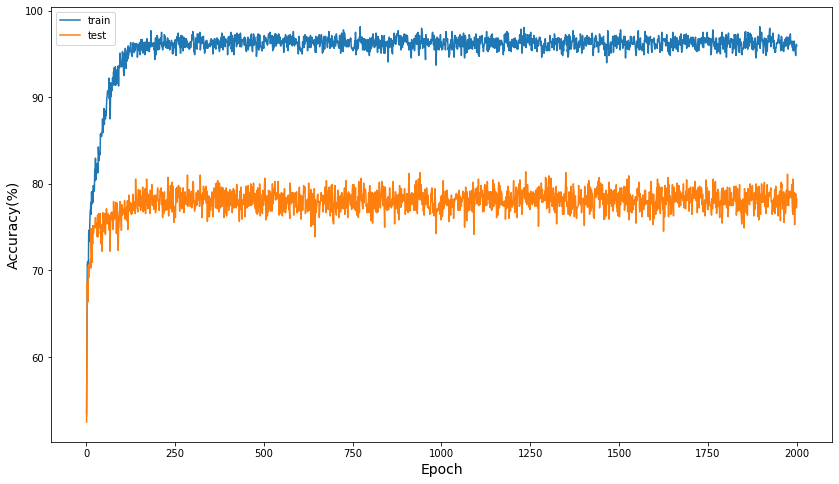

In [50]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 8))

# plt.title("Activation Function comparision(EEGNet)", fontsize=18)
plt.ylabel("Accuracy(%)", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
x = np.arange(1, len(train_acc)+1)
# plt.plot(x, elu_train, label='elu_train')
# plt.plot(x, elu_test, label="elu_test")
# x_relu = np.arange(1, len(relu_train)+1)
# plt.plot(x_relu, relu_train, label="relu_train")
# plt.plot(x_relu, relu_test, label="relu_test")
# plt.plot(x, leakyrelu_train, label="leakyReLU_train")
# plt.plot(x, leakyrelu_test, label="leakyReLU_test")
plt.plot(x, train_acc, label="train")
plt.plot(x, test_acc, label="test")
plt.legend()
plt.show()

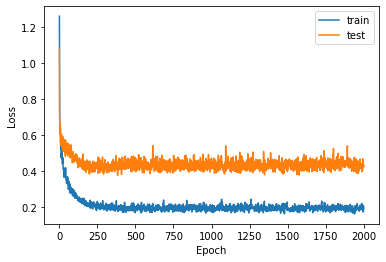

In [42]:
plt.figure()

# plt.title("Activation Function comparision(EEGNet)")
plt.ylabel("Loss")
plt.xlabel("Epoch")
x = np.arange(1, len(train_loss)+1)
plt.plot(x, train_loss, label="train")
plt.plot(x, test_loss, label="test")
plt.legend()
plt.show()

In [43]:
print(max(test_acc))

84.72222222222221


In [49]:
# model_load = EEGNet().to(device)
# model_load.load_state_dict(torch.load(".\EEGNet_weight.pt"))
model_load = torch.load('model.pt', map_location=device)
model_load.eval()

test_loss, correct = 0, 0
pred = model_load(x_test)
test_loss += loss_fn(pred, y_test).item()
correct += (pred.argmax(1) == y_test).type(torch.float).sum().item()

correct /= len(x_test)

print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
print(model_load)
summary(model_load, (1, 2, 750))

Test Error: 
 Accuracy: 82.1%, Avg loss: 0.459051 

DeepConvNet_elu(
  (conv1): Conv2d(1, 25, kernel_size=(1, 5), stride=(1, 1))
  (conv2): Conv2d(25, 25, kernel_size=(2, 1), stride=(1, 1))
  (batchnorm1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(25, 50, kernel_size=(1, 5), stride=(1, 1))
  (batchnorm2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv4): Conv2d(50, 100, kernel_size=(1, 5), stride=(1, 1))
  (batchnorm3): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout3):